<a href="https://colab.research.google.com/github/tony-wade/reverse-engineering/blob/main/WGAN_Recreate_logic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

目標是在 Discriminator的輔助下讓 Generator重現原始資料隱含的數據關聯性。

初步以 RNN測試上下文關聯，發現實際loss無法收斂。接著用結合 Wasserstein 距離和重構損失的 WGAN-GP 架構，來穩定的學習訊號。然而，儘管訓練集損失有所下降，模型在測試集上的表現卻沒有進展，懷疑數據具極高非線性特性，使其難以被目前的模型捕捉和泛化。


## Functions

相關文檔


https://zhuanlan.zhihu.com/p/25071913?source=post_page-----791358c3b10b---------------------------------------

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
#-----------
#資料處理

# 轉換16進位str為二進位
def hex_to_bin(hex_num):
    hex_num_str = str(hex_num)
    binary_num = format(int(hex_num_str, 16), '08b')
    return binary_num


# 讀取excel並將9+5維十六進位data轉成二進位tensor
def process_excel(excel_path):
    df = pd.read_excel(excel_path)

    sca_features = []
    sca_targets = []
    # 前8維為線索 4維為解 二者末端各有1維驗證碼
    for _, row in df.iterrows():
        feature_row = torch.tensor([int(bit) for hex_num in row[:int(len(row)*8/14)] for bit in hex_to_bin(hex_num)], dtype=torch.float32)  #64筆
        target_row = torch.tensor([int(bit) for hex_num in row[int(len(row)*9/14): int(len(row)*13/14)] for bit in hex_to_bin(hex_num)], dtype=torch.float32)   #32筆

        sca_features.append(feature_row)
        sca_targets.append(target_row)

    features = torch.stack(sca_features)
    targets = torch.stack(sca_targets)

    return features, targets


# 定義dataset
class CustomDataset(Dataset):
    def __init__(self, features, targets, labels):
        self.features = features
        self.targets = targets
        self.labels = labels  # 新增的標籤

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = self.features[idx]
        target = self.targets[idx]
        label = self.labels[idx]  # 取得對應的標籤
        return feature, target, label


# 組出能用dataloader的 datasets
def Datasets(path_correct, path_wrong=None):
    # 切分正確的資料集
    correct_features, correct_targets = process_excel(path_correct)

    # 若少於10筆則對半分, 反之82分
    if len(correct_features) > 10:
        correct_features_train, correct_features_test, correct_targets_train, correct_targets_test = train_test_split(
            correct_features, correct_targets, test_size=0.2, random_state=30
        )
    else:
        correct_features_train, correct_features_test, correct_targets_train, correct_targets_test = train_test_split(
            correct_features, correct_targets, test_size=0.5, random_state=12
        )

    # 加上正確數據的標籤
    correct_labels_train = torch.ones([len(correct_features_train), 1], dtype=torch.float32)
    correct_labels_test = torch.ones([len(correct_features_test), 1], dtype=torch.float32)

    # 若提供了 path_wrong
    if path_wrong:
        # 切分錯誤的資料集
        wrong_features, wrong_targets = process_excel(path_wrong)

        # 若少於10筆則對半分, 反之82分
        if len(wrong_features) > 10:
            wrong_features_train, wrong_features_test, wrong_targets_train, wrong_targets_test = train_test_split(
                wrong_features, wrong_targets, test_size=0.2, random_state=15
            )
        else:
            wrong_features_train, wrong_features_test, wrong_targets_train, wrong_targets_test = train_test_split(
                wrong_features, wrong_targets, test_size=0.5, random_state=12
            )

        # 加上錯誤數據的標籤
        wrong_labels_train = torch.zeros([len(wrong_features_train), 1], dtype=torch.float32)
        wrong_labels_test = torch.zeros([len(wrong_features_test), 1], dtype=torch.float32)

        # 合併訓練集和測試集的樣本和標籤
        features_train = torch.cat([correct_features_train, wrong_features_train])
        targets_train = torch.cat([correct_targets_train, wrong_targets_train])
        labels_train = torch.cat([correct_labels_train, wrong_labels_train])

        features_test = torch.cat([correct_features_test, wrong_features_test])
        targets_test = torch.cat([correct_targets_test, wrong_targets_test])
        labels_test = torch.cat([correct_labels_test, wrong_labels_test])
    else:
        # 若未提供 path_wrong，則只使用正確數據
        features_train = correct_features_train
        targets_train = correct_targets_train
        labels_train = correct_labels_train

        features_test = correct_features_test
        targets_test = correct_targets_test
        labels_test = correct_labels_test

    # 創建 CustomDataset
    train_dataset_correct = CustomDataset(correct_features_train, correct_targets_train, correct_labels_train)
    train_dataset = CustomDataset(features_train, targets_train, labels_train)
    test_dataset = CustomDataset(features_test, targets_test, labels_test)


    return train_dataset_correct, train_dataset, test_dataset

# 整數化,將 tensor中的值轉換為 1 或 0
def threshold_tensor(tensor, threshold):
    result_tensor = (tensor > threshold).float()
    return result_tensor

# 二進位轉十六進制
def bin_to_hex(bin_str):
    decimal_num = int(bin_str, 2)
    hex_num = hex(decimal_num)[2:].zfill(len(bin_str) // 4)
    return hex_num

# 將二進制 Tensor 轉換為十六進制數據
def reverse_process_tensor(binary_tensor):
    hex_values = []
    for row in binary_tensor:
        binary_str = ''.join([str(int(bit)) for bit in row])
        hex_val = bin_to_hex(binary_str)
        # 將每個十六進制值拆分成兩位一組
        hex_values.extend([hex_val[i:i+2] for i in range(0, len(hex_val), 2)])

    return hex_values

# 儲存生成資料
def Save_to_excel(save_path, binary_data):
    # 逆向操作，將二進制 Tensor 轉換為十六進制數據
    hex_values = reverse_process_tensor(binary_data)

    try:
        # 試圖打開現有的 Excel 文件
        with pd.ExcelWriter(save_path, mode='w', engine='openpyxl') as writer:
            hex_rows = [f'0x{hex_val}' for hex_val in hex_values]

            # 將 hex_rows 按照每13筆分組
            hex_grouped = [hex_rows[i:i+14] for i in range(0, len(hex_rows), 14)]

            # 將每組 hex_values 寫入 Excel 的不同行
            for row_idx, hex_group in enumerate(hex_grouped):
                pd.DataFrame({'Hex_Values': hex_group}).T.to_excel(writer, index=False, header=False, startrow=row_idx)
    except FileNotFoundError:
        # 如果文件不存在，則新建一個文件
        df = pd.DataFrame({'Hex_Values': hex_values})
        df.T.to_excel(save_path, index=False, header=False, engine='openpyxl')


## The prove that text is ciphered



晶片由主晶片訊號所供電，且工作週期極短，查兩三次表就是極限(by CTO)

有可能是純加/解密，訊號正確與否由主晶片判定


```
AES Mixcolumn?
[f2, 06, a3, 6e] 無法用常規mixcol matrix計算後轉換成 [ed, f6, f5, d6]


*   假設有一key要xor:  
      *   後置則還要xor[d5,98,ee,a2]​, 但其餘資料皆無法成立
      *   前置亦不合理

*   假設是AES S-BOX:
      則 0xc5對應到0x9c 和 0x05...,不合理

*   假設是一輪AES: 數據不吻合(key不同)

```



### Preliminary RNN test

In [3]:
# 定義模型
class SequenceClassifier(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SequenceClassifier, self).__init__()
        # GRU, 讓batch排序先於seq
        self.gru = nn.GRU(input_size, hidden_size, num_layers=3, batch_first=True)

    def forward(self, x):
        # 須提供sequence len = 詞的長度；
        x = x.unsqueeze(1)
        out,_ = self.gru(x)
        out = out[:, -1, :]  # (batch_size,seq_len,hidden_size) -> (batch_size,hidden_size)
        return out


# 指定的 Excel 檔案路徑
excel_path_correct = 'data_correct.xlsx'      # 正確的data
excel_path_wrong = 'data_wrong.xlsx'       # 錯誤的data


# 產生 Datasets
training_set, test_set, gan_training_set = Datasets(excel_path_correct, excel_path_wrong)

# 載入 DataLoader
train_loader = DataLoader(training_set, batch_size=10, shuffle=True)
test_loader = DataLoader(test_set, batch_size=10, shuffle=False)

# 定義模型參數
input_size = 64  # 語詞的特徵大小
hidden_size = 32  # 輸出層大小


# 建立模型
model = SequenceClassifier(input_size, hidden_size)

# 定義損失函數和優化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)



num_epochs = 200
for epoch in range(num_epochs):
    # 訓練模型
    model.train()
    for datas, targets, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(datas)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    # 測試模型
    model.eval()
    for datas, targets, labels in test_loader:
        outputs = model(datas)
        real_loss = criterion(outputs, targets)

    if (epoch + 1) % 10 == 0:
         print("Training [{:.0f}%]\t  Loss: {:.4f}\t | Real Loss: {:.4f} ".format(
                100.0 * (epoch + 1) / num_epochs, loss.item(), real_loss.item()))


Training [5%]	  Loss: 0.2465	 | Real Loss: 0.2549 
Training [10%]	  Loss: 0.2143	 | Real Loss: 0.2814 
Training [15%]	  Loss: 0.1970	 | Real Loss: 0.3093 
Training [20%]	  Loss: 0.1752	 | Real Loss: 0.3282 
Training [25%]	  Loss: 0.1498	 | Real Loss: 0.3613 
Training [30%]	  Loss: 0.1375	 | Real Loss: 0.3621 
Training [35%]	  Loss: 0.1074	 | Real Loss: 0.3680 
Training [40%]	  Loss: 0.1110	 | Real Loss: 0.3742 
Training [45%]	  Loss: 0.0936	 | Real Loss: 0.3877 
Training [50%]	  Loss: 0.0836	 | Real Loss: 0.3931 
Training [55%]	  Loss: 0.0904	 | Real Loss: 0.4073 
Training [60%]	  Loss: 0.0794	 | Real Loss: 0.3982 
Training [65%]	  Loss: 0.0472	 | Real Loss: 0.4082 
Training [70%]	  Loss: 0.0781	 | Real Loss: 0.4190 
Training [75%]	  Loss: 0.0731	 | Real Loss: 0.4266 
Training [80%]	  Loss: 0.0663	 | Real Loss: 0.3979 
Training [85%]	  Loss: 0.0598	 | Real Loss: 0.4081 
Training [90%]	  Loss: 0.0645	 | Real Loss: 0.4126 
Training [95%]	  Loss: 0.0683	 | Real Loss: 0.4029 
Training [100

引用現成 RNN測試後發現無法習得實際隱含規律

### WGAN-GP

In [4]:
#------------
# 設定NN

# Generator
class GenNetwork(nn.Module):
    def __init__(self):
        super(GenNetwork, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(128, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
        )

        # learn
        self.fc2 = nn.Sequential(
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
        )

        # cipher
        self.fc3 = nn.Sequential(
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.2),
        )

        # Initialize the weights
        self.init_weights()

    def init_weights(self):
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                init.xavier_uniform_(layer.weight)
                init.zeros_(layer.bias)

    def forward(self, x):
        out = self.fc1(x)
        out = out + self.fc2(out)  # Residual
        out = self.fc3(out)
        return out



# Discriminator
class DisNetwork(nn.Module):
    def __init__(self):
        super(DisNetwork, self).__init__()
        self.fc1 = nn.Sequential(  # entire line + result(4 bytes)
            nn.Linear(96, 288),
            nn.LeakyReLU(0.2),
            nn.Linear(288, 96),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
        )

        self.fc2 = nn.Sequential(
            nn.Linear(96, 192),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            nn.Linear(192, 96),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
        )

        self.fc3 = nn.Sequential(
            nn.Linear(96, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 1),  # WGAN
        )

        # Initialize the weights
        self.init_weights()

    def init_weights(self):
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                init.xavier_uniform_(layer.weight)
                init.zeros_(layer.bias)     # Optional: initialize biases to zeros

    def forward(self, x):
        out = x + self.fc1(x)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [5]:
def compute_gradient_penalty(discriminator, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = torch.randn(real_samples.size(0), 1).to(real_samples.device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)

    d_interpolates = discriminator(interpolates)

    # Get gradient w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones(d_interpolates.size()).to(real_samples.device),
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [36]:
#------------
# Manual Part

# 指定的 Excel 檔案路徑
excel_path_correct = 'data_correct.xlsx'      # 正確的data
excel_path_wrong = 'data_wrong.xlsx'       # 錯誤的data
excel_path_pending = 'data_correct.xlsx'       # 待生成key的data
save_path = 'generated_key_with_data.xlsx'      # 存放位置


num_epochs = 1000
batch_size = 20

Generator = GenNetwork()
Discriminator = DisNetwork()

loss_func_gen = nn.SmoothL1Loss()
loss_func_dis = nn.SmoothL1Loss()
optimizer_gen = torch.optim.Adam(Generator.parameters(), lr=1e-4)
optimizer_dis = torch.optim.Adam(Discriminator.parameters(), lr=1e-4)

gen_scheduler = lr_scheduler.StepLR(optimizer_gen, step_size=250, gamma=0.3)
dis_scheduler = lr_scheduler.StepLR(optimizer_dis, step_size=250, gamma=0.3)

In [37]:
#-----------------
# Training process

# 產生 Datasets
gan_training_set, dis_training_set, test_set = Datasets(excel_path_correct, excel_path_wrong)

# 載入 DataLoader
gan_training_loader = DataLoader(gan_training_set, batch_size=batch_size, shuffle=True)
dis_training_loader = DataLoader(dis_training_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

# reset
dis_loss_test = []
gen_loss_test = []

dis_loss_train = []
dis_loss_gen = []
gen_loss_train = []


for epoch in range(num_epochs):
    # Train
    Generator.train()
    Discriminator.train()


    train_dis_loss_total = []
    train_gen_loss = []

    lambda_recon = 100
    n_critic = 5

    for _, (data, target, label) in enumerate(gan_training_loader):

        # ---------------------
        # Train Discriminator
        # ---------------------
        key = Generator(data)

        for i in range(n_critic):
            optimizer_dis.zero_grad(set_to_none=True)

            input_real = torch.cat([data, target], dim=1)
            output_real = Discriminator(input_real)
            loss_dis_real = -torch.mean(output_real) # 最大化 real

            input_fake = torch.cat([data, key], dim=1).detach()  # grad only in D
            output_fake = Discriminator(input_fake)
            loss_dis_fake = torch.mean(output_fake) # 最小化 fake

            gradient_penalty = compute_gradient_penalty(Discriminator, input_real, input_fake)

            loss_dis_total = loss_dis_real + loss_dis_fake + 10 * gradient_penalty

            loss_dis_total.backward()
            optimizer_dis.step()

            train_dis_loss_total.append(loss_dis_total.item())


        # -----------------
        #  Train Generator)
        # -----------------
        optimizer_gen.zero_grad(set_to_none=True)

        key_for_gen = Generator(data)
        input_fake_for_gen = torch.cat([data, key_for_gen], dim=1)
        output_fake_for_gen = Discriminator(input_fake_for_gen)

        loss_adv = -torch.mean(output_fake_for_gen)
        recon_loss = loss_func_gen(key_for_gen, target)
        loss_gen_total = loss_adv + lambda_recon * recon_loss

        loss_gen_total.backward()
        optimizer_gen.step()

        train_gen_loss.append(loss_gen_total.item())

    dis_scheduler.step()
    gen_scheduler.step()

    if train_gen_loss and train_dis_loss_total:
        gen_loss_train.append(sum(train_gen_loss) / len(train_gen_loss))
        dis_loss_train.append(sum(train_dis_loss_total) / len(train_dis_loss_total))



    #-----------------
    # Evaluate

    Generator.eval()
    Discriminator.eval()

    # reset for evaluation
    batch_dis_loss = []
    batch_gen_loss = []

    for _, (data, target, label) in enumerate(test_loader):
        # 評估discriminator (以真實資料評估)
        input = torch.cat([data, target], dim=1)
        output = Discriminator(input)
        test_dis_loss = loss_func_dis(output, label)
        batch_dis_loss.append(test_dis_loss.item())


        # 評估generator (以真實資料評估)
        key = Generator(data)
        one_indices = torch.where(label == 1)[0]

        if len(one_indices) > 0:
            test_gen_loss = loss_func_gen(key[one_indices], target[one_indices])
            batch_gen_loss.append(test_gen_loss.item())

    # average per epoch
    dis_loss_test.append(sum(batch_dis_loss) / len(batch_dis_loss))
    gen_loss_test.append(sum(batch_gen_loss) / len(batch_gen_loss))

    if (100.0 * (epoch + 1) / num_epochs) % 10 == 0:
        # D-loss in training | D-loss to test| G-loss to test | Score of D to G
        print("Training [{:.0f}%]\t  Gen_Loss(Train): {:.4f}\t Dis_Loss(Train): {:.4f} | Dis_Loss: {:.4f}\t Gen_Loss: {:.4f}".format(
            100.0 * (epoch + 1) / num_epochs, gen_loss_train[-1], dis_loss_train[-1], dis_loss_test[-1], gen_loss_test[-1]))


    """
    # Save file(w,b)
    if dis_loss_test[-1] == min(dis_loss_test):
        torch.save(Discriminator.state_dict(), "coff_Dis.pt")
        torch.save(Generator.state_dict(), "coff_GNN.pt")

    # Save model
    # torch.save(Generator, "GNN-1.pt")
    # torch.save(Discriminator, "GNN-2.pt")

    """

Training [10%]	  Gen_Loss(Train): 11.6782	 Dis_Loss(Train): -2.1301 | Dis_Loss: 1.3028	 Gen_Loss: 0.1302
Training [20%]	  Gen_Loss(Train): 10.1944	 Dis_Loss(Train): -1.9020 | Dis_Loss: 1.5157	 Gen_Loss: 0.1360
Training [30%]	  Gen_Loss(Train): 9.5462	 Dis_Loss(Train): -1.7855 | Dis_Loss: 1.1771	 Gen_Loss: 0.1401
Training [40%]	  Gen_Loss(Train): 9.4296	 Dis_Loss(Train): -1.7338 | Dis_Loss: 1.1340	 Gen_Loss: 0.1414
Training [50%]	  Gen_Loss(Train): 9.3236	 Dis_Loss(Train): -1.6775 | Dis_Loss: 1.1094	 Gen_Loss: 0.1427
Training [60%]	  Gen_Loss(Train): 8.9641	 Dis_Loss(Train): -1.6554 | Dis_Loss: 1.0423	 Gen_Loss: 0.1433
Training [70%]	  Gen_Loss(Train): 9.0416	 Dis_Loss(Train): -1.6516 | Dis_Loss: 0.9972	 Gen_Loss: 0.1432
Training [80%]	  Gen_Loss(Train): 8.9007	 Dis_Loss(Train): -1.6455 | Dis_Loss: 1.0047	 Gen_Loss: 0.1430
Training [90%]	  Gen_Loss(Train): 8.9178	 Dis_Loss(Train): -1.6395 | Dis_Loss: 0.9860	 Gen_Loss: 0.1431
Training [100%]	  Gen_Loss(Train): 9.0297	 Dis_Loss(Train): -1

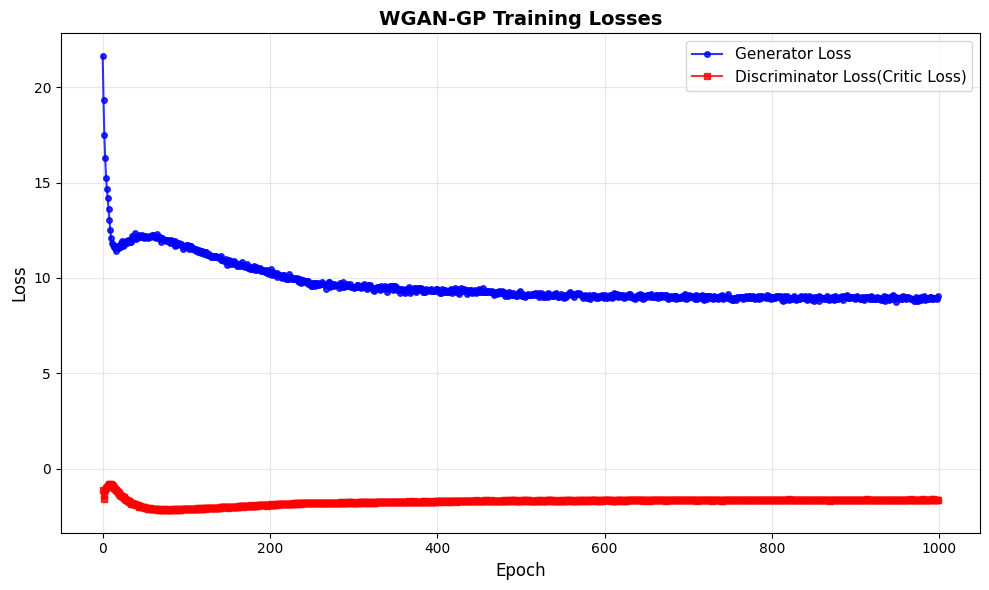

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(gen_loss_train, color='blue', marker='o',
         markersize=4, label='Generator Loss', alpha=0.8)
plt.plot(dis_loss_train, color='red',marker='s',
         markersize=4, label='Discriminator Loss(Critic Loss)', alpha=0.8)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('WGAN-GP Training Losses', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
features, targets = process_excel(excel_path_pending)
labels = torch.zeros([len(features),1], dtype=torch.float32)    # size對就好
pending_set = CustomDataset(features, targets, labels)
pending_loader = DataLoader(pending_set, batch_size=1, shuffle=False)

with torch.no_grad():
    Generator.eval()
    Discriminator.eval()

    all_data = []
    reliability_gen = []
    reliability_raw = []

    for _, (data, target, label) in enumerate(pending_loader):
        # 生成資料
        key = Generator(data)
        key_int = threshold_tensor(key, 0.5)
        input = torch.cat([data, key_int], dim=1)
        score_gen = Discriminator(input)

        # 檢查discriminator效能 & input錯誤率
        input_raw = torch.cat([data, target], dim=1)
        score_raw = Discriminator(input_raw)

        # 蒐集每個批次的資料
        all_data.append(input)
        reliability_raw.append(torch.mean(score_raw).item())
        reliability_gen.append(torch.mean(score_gen).item())

    # 將所有批次的資料組合在一起
    all_data = torch.cat(all_data, dim=0)

    Save_to_excel(save_path, all_data)


    print("Reliability of generated data [{:.2f}%]\tReliability of raw data [{:.2f}%]".format(
            100*sum(reliability_gen)/len(reliability_gen), 100*sum(reliability_raw)/len(reliability_raw)))